In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import datetime
from sklearn.neighbors import KNeighborsClassifier

In [2]:
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

## Preprocessing

### Contract

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
#renaming columns
contract.rename({'customerID' : 'customer_id',
                'BeginDate': 'begin_date',
                'EndDate': 'end_date',
                'Type': 'type',
                'PaperlessBilling': 'paperless_billing',
                'PaymentMethod': 'payment_method',
                'MonthlyCharges': 'monthly_charges',
                'TotalCharges': 'total_charges'},
                axis=1, inplace=True)

In [6]:
#changing datatypes
contract['begin_date']= pd.to_datetime(contract['begin_date'])

In [7]:
contract['total_charges'].isna().values.any()

False

In [8]:
#percentage of missing values
(len(contract[contract['total_charges'] == ' ']) / len(contract['total_charges'])) * 100

0.1561834445548772

In [9]:
#dropping missing values as it's only 0.15% of the data
contract['total_charges'].replace(' ', np.nan, inplace=True)

In [10]:
contract.dropna(subset=['total_charges'],inplace=True)

In [11]:
#changing the datatype
contract['total_charges'] = contract['total_charges'].astype('float')

In [12]:
#checking for empty strings
contract[contract['end_date'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


In [13]:
#creating the target column
def target_column(end_date):
    if end_date == 'No':
        return 'no churn'
    
    else:
        return 'churn'

In [14]:
contract['target'] = contract['end_date'].apply(target_column)

In [15]:
contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,no churn
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,no churn
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,churn
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,no churn
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,churn
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,no churn
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,no churn
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,no churn
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,churn


In [16]:
contract['total_charges'].isna().sum()

0

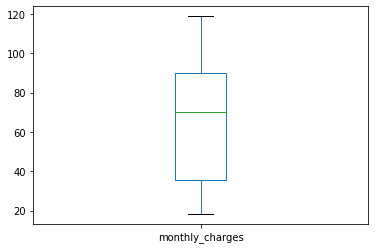

In [17]:
#Outliers
contract['monthly_charges'].plot(kind='box')
plt.show()

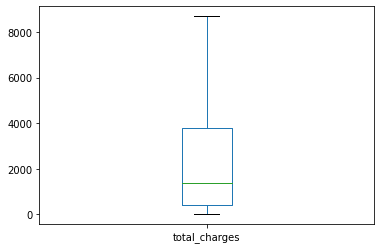

In [18]:
contract['total_charges'].plot(kind='box')
plt.show()

### Internet

In [19]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [20]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [21]:
#renaming columns
internet.rename({'customerID' : 'customer_id',
                 'InternetService': 'internet_service',
                 'OnlineSecurity': 'online_security',
                 'OnlineBackup': 'online_backup',
                 'DeviceProtection': 'device_protection',
                 'TechSupport': 'tech_support',
                 'StreamingTV': 'streaming_tv',
                 'StreamingMovies': 'streaming_movies'},
                axis=1, inplace=True)

In [22]:
internet[['internet_service', 
          'online_security', 
          'online_backup', 
          'device_protection',
          'tech_support',
          'streaming_tv',
          'streaming_movies']].apply(pd.Series.value_counts)

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
DSL,2421.0,NaN,NaN,NaN,NaN,NaN,NaN
Fiber optic,3096.0,NaN,NaN,NaN,NaN,NaN,NaN
No,NaN,3498.0,3088.0,3095.0,3473.0,2810.0,2785.0
Yes,NaN,2019.0,2429.0,2422.0,2044.0,2707.0,2732.0


### Personal

In [23]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [24]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [25]:
personal.rename({'customerID': 'customer_id',
                'SeniorCitizen': 'senior_citizen',
                'Partner': 'partner',
                'Dependents': 'dependents'},
               axis=1, inplace=True)

### Phone

In [26]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [27]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [28]:
phone.rename({'customerID':'customer_id',
             'MultipleLines': 'multiple_lines'},
            axis=1, inplace=True)

In [29]:
phone.isna().values.any()

False

In [30]:
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

- The ratio of having multiple lines or not having a multiple lines is almost 1

In [31]:
#merging all the datasets
df = contract.merge(internet, on='customer_id', how='left')\
            .merge(phone, on='customer_id', how='left')\
            .merge(personal, on='customer_id', how='left')

In [32]:
df.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,no churn,DSL,...,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,no churn,DSL,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,churn,DSL,...,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,no churn,DSL,...,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,churn,Fiber optic,...,No,No,No,No,No,No,Female,0,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,churn,Fiber optic,...,No,Yes,No,Yes,Yes,Yes,Female,0,No,No
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,no churn,Fiber optic,...,Yes,No,No,Yes,No,Yes,Male,0,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,no churn,DSL,...,No,No,No,No,No,NaN,Female,0,No,No
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,churn,Fiber optic,...,No,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,No
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,no churn,DSL,...,Yes,No,No,No,No,No,Male,0,No,Yes


In [33]:
#Checking for missing values
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
gender                  0
senior_citizen          0
partner                 0
dependents              0
dtype: int64

In [34]:
#Filling only this columns' missing values with 'N/A' because I will replace 'No' values with 0. 
df['internet_service'].fillna('N/A', inplace=True)

In [35]:
#Filling missing values with "no" as it indicates that the customer does not have that particular service. 
df.fillna('No', inplace=True)

In [36]:
#Replacing Yes/No values with 1/0.
df.replace(['Yes','No'],['1','0'], inplace=True)

## EDA

#### Personal

In [37]:
personal[['gender', 'senior_citizen', 'partner', 'dependents']].apply(pd.Series.value_counts)

,gender,senior_citizen,partner,dependents
0,NaN,5901.0,NaN,NaN
1,NaN,1142.0,NaN,NaN
Female,3488.0,NaN,NaN,NaN
Male,3555.0,NaN,NaN,NaN
No,NaN,NaN,3641.0,4933.0
Yes,NaN,NaN,3402.0,2110.0


- The customers are mostly adults which can ce concluded from not being a senior nor a dependent

- The ratio between the number of males and females is almost 1 

- The ratio of having a partner and not having a partner is almost 1

#### How long does it take for a customer to leave?

In [38]:
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

In [39]:
delta = df['end_date'] - df['begin_date']

In [40]:
delta.describe()

count                           1869
mean     547 days 08:26:57.977528088
std      594 days 09:21:02.012639256
min                 30 days 00:00:00
25%                 61 days 00:00:00
50%                304 days 00:00:00
75%                883 days 00:00:00
max               2191 days 00:00:00
dtype: object

- In average, It takes about 547 days for a customer to churn.

#### Seasonality

In [41]:
#Feature Engineering
df['log_monthly'] = np.log(df['monthly_charges'])
df['log_total'] = np.log(df['total_charges'])
df['begin_year'] = df['begin_date'].dt.year
df['begin_month'] = df['begin_date'].dt.month
df['begin_day'] = df['begin_date'].dt.day
df['begin_dayofweek'] = df['begin_date'].dt.dayofweek
df['delta'] = (df['end_date'] - df['begin_date']).dt.days

In [42]:
days_passed = (pd.to_datetime(datetime.date.today()) - df['begin_date']).dt.days

In [43]:
df['delta'].replace({np.nan: None}, inplace=True)

In [44]:
df['delta'].fillna(days_passed, inplace=True)

In [45]:
df['quarter'] = df['begin_date'].dt.quarter

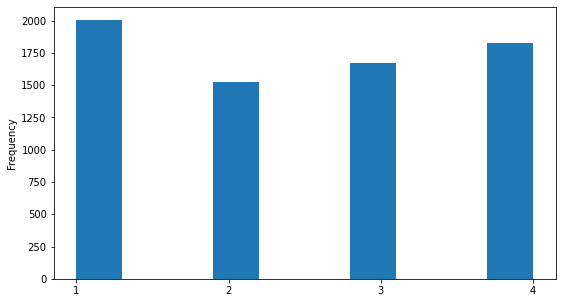

In [46]:
df['quarter'].plot(kind='hist', figsize=(9,5))

plt.xticks(np.arange(min(df['quarter']), max(df['quarter'])+1, 1.0))
plt.show()

- First quarter of the year is when most customers are attracted. 

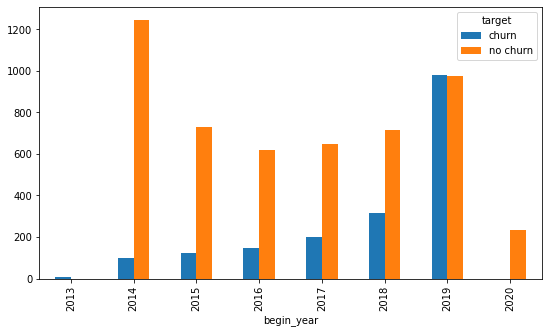

In [47]:
df2=df.groupby(['begin_year','target']).size()
df2=df2.unstack()
ax = df2.plot(kind='bar', figsize=(9,5))

plt.show()

- There's a significant increase of customers that churn on 2019.

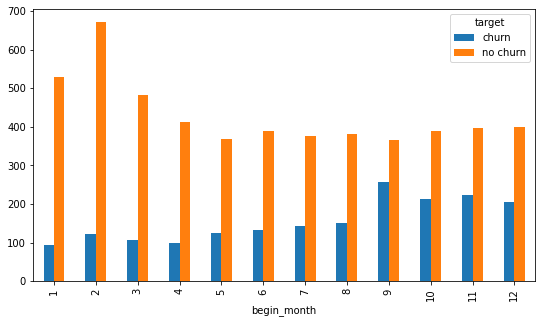

In [48]:
df3=df.groupby(['begin_month','target']).size()
df3=df3.unstack()
ax = df3.plot(kind='bar', figsize=(9,5))


plt.show()

- Last quarter of the year is when the number of customers that churn increases. 

#### Does having multiple lines encourage customers to stay?

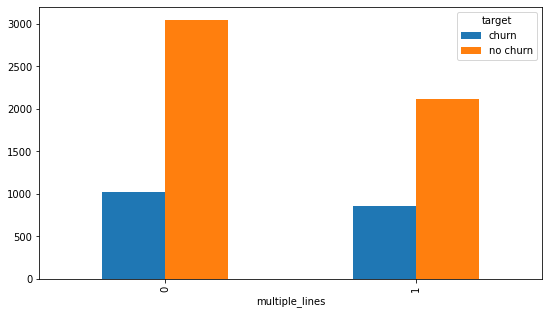

In [49]:
df4=df.groupby(['multiple_lines','target']).size()
df4=df4.unstack()

ax = df4.plot(kind='bar', figsize=(9,5))


plt.show()

In [50]:
df['multiple_lines'].value_counts()

0    4065
1    2967
Name: multiple_lines, dtype: int64

In [51]:
df2

target,churn,no churn
begin_year,,
2013,8.0,NaN
2014,98.0,1246.0
2015,123.0,729.0
2016,145.0,618.0
2017,199.0,646.0
2018,315.0,715.0
2019,981.0,976.0
2020,NaN,233.0


- Having a multiple or a single line does not have a significant effect on leaving. 

#### How much does a customer pay in average (monthly and total)?

In [52]:
df.pivot_table(index='type',values=['monthly_charges','total_charges'])\
  .sort_values(by='type', ascending=False)

,monthly_charges,total_charges
type,,
Two year,60.872374,3728.933947
One year,65.079416,3034.683084
Month-to-month,66.398490,1369.254581


In [53]:
df_churn = df.query('target == "churn"')
df_churn.pivot_table(index='type',values=['monthly_charges','total_charges'])\
        .sort_values(by='type', ascending=False)

,monthly_charges,total_charges
type,,
Two year,86.777083,5432.363542
One year,85.050904,4066.212048
Month-to-month,73.019396,1164.460574


In [54]:
df_no_churn = df.query('target == "no churn"')
df_no_churn.pivot_table(index='type',values=['monthly_charges','total_charges'])\
           .sort_values(by='type', ascending=False)

,monthly_charges,total_charges
type,,
Two year,60.112798,3678.986103
One year,62.540926,2903.569908
Month-to-month,61.462635,1521.927590


- Customers who churned were paying relatively higher compared to customers who didn't churn.

#### What internet services do most customers have and does using more services encourage customers to stay?

In [55]:
df[['online_security', 
        'online_backup', 
        'device_protection', 
        'tech_support', 
        'streaming_tv', 
        'streaming_movies']] = df[['online_security', 
                                    'online_backup', 
                                    'device_protection', 
                                    'tech_support', 
                                    'streaming_tv', 
                                    'streaming_movies']].astype('int')

In [56]:
df.pivot_table(index='internet_service',
               values=['online_security', 
                       'online_backup', 
                       'device_protection', 
                       'tech_support', 
                       'streaming_tv', 
                       'streaming_movies'],
               columns='target')

device_protection           online_backup            \
target                       churn  no churn         churn  no churn   
internet_service                                                       
DSL                       0.254902  0.482371      0.252723  0.493613   
Fiber optic               0.329992  0.516398      0.313801  0.520289   
N/A                       0.000000  0.000000      0.000000  0.000000   

                 online_security           streaming_movies            \
target                     churn  no churn            churn  no churn   
internet_service                                                        
DSL                     0.244009  0.543689         0.298475  0.430761   
Fiber optic             0.141095  0.364647         0.525058  0.594775   
N/A                     0.000000  0.000000         0.000000  0.000000   

                 streaming_tv           tech_support            
target                  churn  no churn        churn  no churn  
internet_service                                                
DSL                  0.276688  0.422075     0.248366  0.541645  
Fiber optic          0.529684  0.590884     0.151118  0.372429  
N/A                  0.000000  0.000000     0.000000  0.000000

- This table shows the percentage of customers who had/have the particular service and whether churned or did not churn. 

- For example, 33% of fiber optic customers who had device protection churned. (67% did not churn)

- There's no relation in having a particular service and churning. 

## Model Training

In [57]:
df_ohe = pd.get_dummies(df,columns=['type','internet_service', 'gender'],  drop_first=True)

In [58]:
categorical_feats=['paperless_billing', 
                   'multiple_lines', 
                   'partner', 
                   'dependents'
                   ]

for c in categorical_feats:
    df_ohe[c] = df_ohe[c].astype('int')

In [59]:
df_ohe['target'].replace(['churn', 'no churn'], [1,0], inplace=True)

In [60]:
#Features and target
x = df_ohe.drop(['customer_id', 'target', 'begin_date','end_date','payment_method', 'delta','begin_day', 'begin_dayofweek', 'paperless_billing'], axis=1)
y = df_ohe['target']

In [61]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state=42) 

In [62]:
#Scaling
scaler = StandardScaler()

numeric=['monthly_charges',
        'total_charges'
        ]

x_scaled = x_train[numeric]
x_t_scaled = x_test[numeric]

scaler.fit(x_scaled)

x_scaled= scaler.transform(x_scaled)
x_t_scaled = scaler.transform(x_t_scaled)

In [63]:
#Upsampling
def upsample(x, y, repeat):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + ([x_ones] * repeat))
    y_upsampled = pd.concat([y_zeros] + ([y_ones] * repeat))

    x_upsampled, y_upsampled = shuffle(
        x_upsampled, y_upsampled, random_state=42)

    return x_upsampled, y_upsampled

x_upsampled, y_upsampled = upsample(x_train, y_train, 3)

In [609]:
y_upsampled.value_counts()

1    3924
0    3614
Name: target, dtype: int64

### Logistic Regression 

In [533]:
model_log = LogisticRegression(random_state=42,solver='liblinear')

In [534]:
score = cross_val_score(model_log, x_upsampled,y_upsampled, cv=5, scoring='roc_auc')
print('ROC_AUC =', score)

ROC_AUC = [0.86834228 0.85417625 0.84367506 0.86276444 0.85515285]


### Decision Tree

In [553]:
param_desc = {'max_depth' : [1,2,3,4,5,6,7,8,9,10]}

In [554]:
model_desc = DecisionTreeClassifier(random_state = 42)

In [555]:
grid_desc = GridSearchCV(model_desc, param_desc, cv=5, n_jobs=5, scoring='roc_auc')

In [556]:
grid_desc.fit(x_upsampled,y_upsampled)
print('Best Parameters:',grid_desc.best_params_)
print('Best Score:',grid_desc.best_score_)

Best Parameters: {'max_depth': 10}
Best Score: 0.9092711909568901


### Random Forest

In [557]:
param_rand = {'max_depth': [1,2,3,4,5,6,7,8,9,10],
              'n_estimators': [5,6,7,8,9,10,11,12,13,14,15]}

In [558]:
model_rand = RandomForestClassifier(random_state=42)

In [559]:
grid_rand = GridSearchCV(model_rand, param_rand, cv=5, n_jobs=5, scoring='roc_auc')

In [560]:
grid_rand.fit(x_upsampled,y_upsampled)
print('Best Parameters:',grid_rand.best_params_)
print('Best Score:',grid_rand.best_score_)

Best Parameters: {'max_depth': 10, 'n_estimators': 15}
Best Score: 0.9376428153456242


### LightGBM

In [64]:
param_gbm = {'learning_rate': [1, 0.1,0.001],
         'max_depth': [3,4,5,6,7,8,9],
         'num_leaves': [13,14,15,16,17,18]
          }

In [65]:
model_gbm = LGBMClassifier(random_state=42, objective='binary',metric='roc_auc')

In [66]:
grid_gbm = GridSearchCV(model_gbm, param_gbm, cv=5, n_jobs=5, scoring='roc_auc',verbose=-1)

In [67]:
grid_gbm.fit(x_upsampled,y_upsampled)
print('Best Parameters:',grid_gbm.best_params_)
print('Best Score:',grid_gbm.best_score_)

Best Parameters: {'learning_rate': 1, 'max_depth': 7, 'num_leaves': 18}
Best Score: 0.9891620496983897


## Testing

In [68]:
model = LGBMClassifier(**grid_gbm.best_params_,random_state=42)

In [69]:
model.fit(x_upsampled,y_upsampled)

LGBMClassifier(learning_rate=1, max_depth=7, num_leaves=18, random_state=42)

In [72]:
y_pred = model.predict_proba(x_test)[:, 1]

In [73]:
print('ROC-AUC Score = ', roc_auc_score(y_test, y_pred))

ROC-AUC Score =  0.910619121761035


[0.        0.7486631 1.       ]
[0.         0.08650742 1.        ]
[2 1 0]
0.8310778387298343
Threshold value is: 1


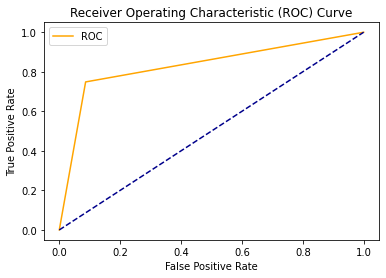

In [552]:
#ROC-AUC Curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_test, y_pred))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

### Report Questions

-All steps of the work plan was performed except splitting data in train, validation, and test sets. Cross-Validation was used, therefore the data was split into train(0.7) and test (0.3) sets. 

-One of the biggest problems I encountered was the NaT types in end_date column. I created days_passed column based on begin_date and end_date columns but missing dates(meaning no churn) created a problem during model training. I've tried replacing them with 'None', they were still NaTTypes. So, I replaced them with the amount of days passed from the day they got a service and today's date. Feature engineering was another problem because creating more features irresponsibly can result in overfitting. So, I kept trying back and forth to figure out what features would I benefit the most. 


-I think preprocessing and feature engineering are the key steps in all projects. If you spend decent amount of preparing the data and finding ways to create more features, the rest seems to be easier to deal with and the chance of getting an error lower. For example, I could've dealt with NaTTypes before going into model training because it took me more time to understand what was causing the problem. 


-The final model is LightGBM and the score is 0.91 on the test set. 

